### Import Packages

In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_validate
import numpy as np
import pandas as pd
import os, sys


In [2]:
os.getcwd()

'c:\\Users\\user\\mimic\\mimic-iv\\ml'

In [3]:
df = pd.read_csv('C:/Users/user/mimic/Mimic-iv/csv/df.csv')

In [4]:
df['afib_within_7days'].value_counts()

0    13397
1     4595
Name: afib_within_7days, dtype: int64

In [5]:
exclude_vars = ['time','_id','duration','death','dod',
'cvicu','first_careunit',
'inhos','90','t2e','ethnicity','gender','crrt_after_afib','ventil_usage_before_afib',
'ventil_usage','ventil_usage_after_afib','afib_newonset','after_afib','exclusion','weight','height']
expr = '|'.join(exclude_vars)

mask= df.columns.str.contains(expr)==False
df = df.iloc[:,mask]

In [6]:
df['dex_usage'].value_counts()

0    14935
1     3057
Name: dex_usage, dtype: int64

### Preprocessing

#### Outlier

In [7]:
exception = ['afib_within_7days','dex_usage']
for i in df.loc[:,df.dtypes!='object'].columns:
    if i not in exception :
        Q1, Q3 = df[i].quantile([0.25,0.75]).values
        IQR = Q3 - Q1
        minimum, maximum = (Q1-1.5*IQR), (Q3 + 1.5 * IQR)
        for j in range(df[i].shape[0]):
            if (df[i][j] < minimum) | (df[i][j]>maximum): df[i][j] = np.nan
            

C:\Users\user\miniconda3\envs\mimic4\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\user\AppData\Local\Temp/ipykernel_22064/1495625771.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if (df[i][j] < minimum) | (df[i][j]>maximum): df[i][j] = np.nan


In [8]:
df['dex_usage'].value_counts()

0    14935
1     3057
Name: dex_usage, dtype: int64

#### imputation

<AxesSubplot:xlabel='value', ylabel='count'>

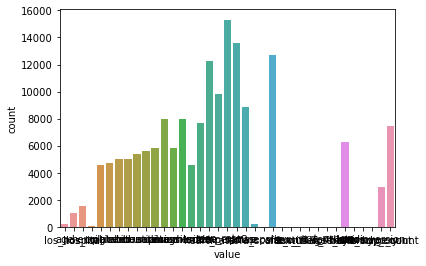

In [9]:
import seaborn as sns
naDf = pd.DataFrame(df.isna().sum())
naDf.index.name='value'
naDf.rename(columns={0:'count'}, inplace=True)
naDf.reset_index(inplace=True)
naDf

sns.barplot(data=naDf, x='value', y='count')

In [10]:
imputation_target = df.loc[:,df.isnull().sum()>0].columns
df = df.fillna(df.median())

C:\Users\user\AppData\Local\Temp/ipykernel_22064/3337489165.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.median())



#### Scaling
- chr -> one-hot encoding
- numeric -> standard scaler

In [11]:
onehot_columns = df.loc[:,df.dtypes=='object'].columns

for i in onehot_columns:
    if i=='sex':
        df[i] = np.where(df[i]=='Female',0,1)
    elif len(df[i].unique())==2:
        df[i] = np.where(df[i]=='Yes',1,0)
    else:
        pass


In [12]:
onehot_encoder = OneHotEncoder()
onehot_result = onehot_encoder.fit_transform(df[['icuunit']])

# onehot_result
onehot_result_df = pd.DataFrame(onehot_result.toarray(),columns=['CCU','CVICU','ETC','MICU','SICU'])
onehot_result_df.columns

Index(['CCU', 'CVICU', 'ETC', 'MICU', 'SICU'], dtype='object')

In [13]:
df = df.drop('icuunit',axis=1)
df = pd.concat([df, onehot_result_df],axis=1)

#### CHECK VIF

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import statsmodels.api as sm

In [15]:
target = 'afib_within_7days'
x= list(df.columns)
x.remove('afib_within_7days')
xs = "+".join(x)
form = target + "~" + xs

Y,X = dmatrices(form, df, return_type='dataframe')
vif =pd.DataFrame()
vif['VIF factor'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif

C:\Users\user\miniconda3\envs\mimic4\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\user\miniconda3\envs\mimic4\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\user\miniconda3\envs\mimic4\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF factor,features
0,0.000000,Intercept
1,1.695913,age
2,1.175229,los_hospital
3,1.220383,los_icu
4,1.707748,cci
5,1.237711,hemoglobin
6,1.223837,platelet
7,1.134848,wbc
8,1.334389,bicarbonate
9,1.530515,bun


### Modeling

In [16]:

y = df['afib_within_7days']
x = df.iloc[:,df.columns != 'afib_within_7days']
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=7795, test_size=0.3)


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score

lr = LogisticRegression().fit(x_train,y_train)
rf = RandomForestClassifier().fit(x_train,y_train)
xgb = XGBClassifier().fit(x_train, y_train)
lgbm = LGBMClassifier().fit(x_train,y_train)
mlp = MLPClassifier().fit(x_train,y_train)

lr_pred = lr.predict_proba(x_test)[:,1]
rf_pred = rf.predict_proba(x_test)[:,1]
xgb_pred = xgb.predict_proba(x_test)[:,1]
lgbm_pred = lgbm.predict_proba(x_test)[:,1]
mlp_pred = mlp.predict_proba(x_test)[:,1]

lr_pred_exact = lr.predict(x_test)
rf_pred_exact = rf.predict(x_test)
xgb_pred_exact = xgb.predict(x_test)
lgbm_pred_exact = lgbm.predict(x_test)
mlp_pred_exact = mlp.predict(x_test)

lr_f1 = f1_score(y_test, lr_pred_exact)
rf_f1 = f1_score(y_test, rf_pred_exact)
xgb_f1 = f1_score(y_test, xgb_pred_exact)
lgbm_f1 = f1_score(y_test, lgbm_pred_exact)
mlp_f1 = f1_score(y_test, mlp_pred_exact)


precision, recall, th, = precision_recall_curve(y_test, rf_pred)
rf_auprc = auc(recall, precision)

precision, recall, th, = precision_recall_curve(y_test, lr_pred)
lr_auprc = auc(recall, precision)

precision, recall, th, = precision_recall_curve(y_test, xgb_pred)
xgb_auprc = auc(recall, precision)

precision, recall, th, = precision_recall_curve(y_test, lgbm_pred)
lgbm_auprc = auc(recall, precision)

precision, recall, th, = precision_recall_curve(y_test, mlp_pred)
mlp_auprc = auc(recall, precision)



lr_roc = roc_auc_score(y_test, lr_pred)
rf_roc = roc_auc_score(y_test, rf_pred)
xgb_roc = roc_auc_score(y_test,xgb_pred)
lgbm_roc = roc_auc_score(y_test, lgbm_pred)
mlp_roc = roc_auc_score(y_test, mlp_pred)





C:\Users\user\miniconda3\envs\mimic4\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\miniconda3\envs\mimic4\lib\site-packages\xgboost\sklearn.py:1212: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,LR,RF,XGB,LGBM,MLP
AUROC,0.924221,0.943241,0.946567,0.952370,0.950716
AUPRC,0.884409,0.911743,0.911976,0.918682,0.916623
F1,0.810539,0.836303,0.837115,0.838421,0.835747


In [34]:
from sklearn.metrics import confusion_matrix

def calc_ppv_npv (y_true, y_predict):
    tn, fp, fn, tp = confusion_matrix(y_true, y_predict).ravel()
    
    result = {}
    result['PPV'] = tp / (tp + fp)
    result['NPV'] = tn / (tn + fn)
    result['sensitivity'] = tp / (tp + fn)
    result['specificity'] = tn / (tn + fp)

    return result

lr_ppv, lr_npv, lr_sensitivity, lr_specificity = calc_ppv_npv(y_test, lr_pred_exact).values()
rf_ppv, rf_npv, rf_sensitivity, rf_specificity = calc_ppv_npv(y_test, rf_pred_exact).values()
xgb_ppv, xgb_npv, xgb_sensitivity, xgb_specificity = calc_ppv_npv(y_test, xgb_pred_exact).values()
lgbm_ppv, lgbm_npv, lgbm_sensitivity, lgbm_specificity = calc_ppv_npv(y_test, lgbm_pred_exact).values()
mlp_ppv, mlp_npv, mlp_sensitivity, mlp_specificity = calc_ppv_npv(y_test, mlp_pred_exact).values()



In [37]:
auroc_list = [lr_roc, rf_roc, xgb_roc, lgbm_roc, mlp_roc]
auprc_list = [lr_auprc, rf_auprc, xgb_auprc, lgbm_auprc, mlp_auprc]
f1_list = [lr_f1, rf_f1, xgb_f1, lgbm_f1, mlp_f1]
ppv_list = [lr_ppv, rf_ppv, xgb_ppv, lgbm_ppv, mlp_ppv]
npv_list = [lr_npv, rf_npv, xgb_npv, lgbm_npv, mlp_npv]
sensitivity_list = [lr_sensitivity, rf_sensitivity, xgb_sensitivity, lgbm_sensitivity, mlp_sensitivity]
specificity_list = [lr_specificity, rf_specificity, xgb_specificity, lgbm_specificity, mlp_specificity]


result = pd.DataFrame([auroc_list, auprc_list, sensitivity_list, specificity_list, ppv_list, npv_list, f1_list], 
                    index=['AUROC','AUPRC','Sensitivity','Specificity','PPV','NPV', 'F1'], 
                                columns=['LR','RF','XGB','LGBM','MLP']).T
result

,AUROC,AUPRC,Sensitivity,Specificity,PPV,NPV,F1
LR,0.924221,0.884409,0.752518,0.963822,0.878254,0.918232,0.810539
RF,0.943241,0.911743,0.725899,0.996507,0.986315,0.912914,0.836303
XGB,0.946567,0.911976,0.743165,0.988772,0.958256,0.917361,0.837115
LGBM,0.952370,0.918682,0.741007,0.990768,0.965323,0.916878,0.838421
MLP,0.950716,0.916623,0.726619,0.995758,0.983447,0.913063,0.835747


### Cross Validation with Parameter Tuning

#### 1. Logistic Regression

In [38]:
from sklearn.model_selection import KFold, RandomizedSearchCV
kf = KFold(random_state=7795, n_splits=5, shuffle=True)

In [39]:
lr = LogisticRegression()
lr_params = {
    'penalty':['l1','l2','elasticnet','none'],
    'C':np.arange(0, 5 ,0.01),
    'max_iter': np.arange(100,500, 100),
    'multi_class':['auto','ovr','multinomial'],
    'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
    'tol': np.arange(1e-4, 1e-3, 0.0001)
}

from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, roc_curve
RSCV_lr = RandomizedSearchCV(lr, lr_params, cv=kf, n_jobs=-1, random_state=7795).fit(x_train,y_train)
RSCV_lr_pred = RSCV_lr.predict_proba(x_test)[:,1]
RSCV_lr_pred_exac = RSCV_lr.predict(x_test)
fpr_lr, tpr_lr, t = roc_curve(y_true=y_test, y_score = RSCV_lr_pred)
precision_lr, recall_lr, th, = precision_recall_curve(y_true=y_test, probas_pred=RSCV_lr_pred)
RSCV_lr_auprc = auc(recall_lr, precision_lr)
RSCV_lr_auroc = roc_auc_score(y_test, RSCV_lr_pred)
RSCV_lr_f1 = f1_score(y_test, RSCV_lr_pred_exac)
print(f"AUPRC of LR: {RSCV_lr_auprc}")
print(f"AUROC of LR: {RSCV_lr_auroc}")
print(f"F1 Score of LR: {RSCV_lr_f1}")
print(RSCV_lr.best_params_)

C:\Users\user\miniconda3\envs\mimic4\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.93219062        nan 0.93234938 0.91869225        nan        nan
 0.88145257 0.92814101 0.91877165        nan]
  warnings.warn(


AUPRC of LR: 0.9173453253458751
AUROC of LR: 0.9511873734545297
F1 Score of LR: 0.8378043747420553
{'tol': 0.0007000000000000001, 'solver': 'liblinear', 'penalty': 'l1', 'multi_class': 'auto', 'max_iter': 400, 'C': 4.33}


#### Support Vector Machine

In [21]:
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.get_params()


{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [22]:
svm_params = {
    'C':np.arange(0.0, 3.0 ,0.5),
    'kernel' : ['linear','poly','rbf','sigmoid'],
    'gamma' : ['sclae','auto'],
    'decision_function_shape': ['ovo','ovr']
}
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, roc_curve
RSCV_svm = RandomizedSearchCV(svm, svm_params, cv=kf, n_jobs=-1, random_state=7795).fit(x_train,y_train)
RSCV_svm_pred = RSCV_svm.predict_proba(x_test)[:,1]
RSCV_svm_pred_exac = RSCV_svm.predict(x_test)
fpr_svm, tpr_svm, t = roc_curve(y_true=y_test, y_score = RSCV_svm_pred)
precision_svm, recall_svm, th, = precision_recall_curve(y_true=y_test, probas_pred=RSCV_svm_pred)
RSCV_svm_auprc = auc(recall_svm, precision_svm)
RSCV_svm_auroc = roc_auc_score(y_test, RSCV_svm_pred)
RSCV_svm_f1 = f1_score(y_test, RSCV_svm_pred_exac)
print(f"AUPRC of svm: {RSCV_svm_auprc}")
print(f"AUROC of svm: {RSCV_svm_auroc}")
print(f"F1 Score of svm: {RSCV_svm_f1}")
print(RSCV_svm.best_params_)

#### 2. Random Forest

In [40]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': np.arange(10,100,10),
    'criterion':['gini','entropy'],
    'max_depth':np.arange(10,100,10),
    'min_samples_leaf': np.arange(1,10,1),
    'min_samples_split': np.arange(2,10,2),
    'max_features':['auto','sqrt','log2'],
    # 'min_impurity_decrease':np.arange(-1,1,0.1),
    # 'class_weight':['balanced','balanced_subsample'],
    # 'ccp_alpha':np.arange(0,1,0.1),
    # 'min_weight_fraction_leaf':np.arange(0,1,0.1)
}

RSCV_rf = RandomizedSearchCV(rf, rf_params, cv=kf, n_jobs=-1, random_state=7795).fit(x_train,y_train)
RSCV_rf_pred = RSCV_rf.predict_proba(x_test)[:,1]
RSCV_rf_pred_exac = RSCV_rf.predict(x_test)
fpr_rf, tpr_rf, th = roc_curve(y_test ,RSCV_rf_pred)
precision_rf, recall_rf, th, = precision_recall_curve(y_test, RSCV_rf_pred)


RSCV_rf_auprc = auc(recall_rf, precision_rf)
RSCV_rf_auroc = roc_auc_score(y_test, RSCV_rf_pred)
RSCV_rf_f1 = f1_score(y_test ,RSCV_rf_pred_exac)

print(f"AUPRC of RF: {RSCV_rf_auprc}")
print(f"AUROC of RF: {RSCV_rf_auroc}")
print(f"F1 score of RF: {RSCV_rf_f1}")

AUPRC of RF: 0.9163004825244929
AUROC of RF: 0.9481754117663952
F1 score of RF: 0.8352013283520133


#### 3. XGBoost

In [41]:
xgb = XGBClassifier()
xgb_params = {
    'booster':['gbtree'],
    'n_estimators': np.arange(10,500,20),
    'learning_rate': np.arange(1e-3,1e-2,1e-3),
    'gamma':[0,1,2,3,4,5,6,7,8,9,10],
    'min_child_weight':np.arange(5,20,5),
    'objective':['binary:logistic'],
    # 'max_depth': np.arange(10,100,10),
    # 'booster':['gbtree','gblinear','dart'],
    # 'tree_method':['gpu_hist','auto','exact','approx','hist'],
    'use_label_encoder':[False],
    # 'sampling_method':['uniform','gradient_based']
}

RSCV_xgb = RandomizedSearchCV(xgb, xgb_params, cv=kf, n_jobs=-1, random_state=7795).fit(x_train,y_train)
RSCV_xgb_pred = RSCV_xgb.predict_proba(x_test)[:,1]
RSCV_xgb_pred_exac = RSCV_xgb.predict(x_test)
fpr_xgb, tpr_xgb, th = roc_curve(y_test ,RSCV_xgb_pred)
precision_xgb, recall_xgb, th, = precision_recall_curve(y_test, RSCV_xgb_pred)


RSCV_xgb_auprc = auc(recall_xgb, precision_xgb)
RSCV_xgb_auroc = roc_auc_score(y_test, RSCV_xgb_pred)
RSCV_xgb_f1 = f1_score(y_test, RSCV_xgb_pred_exac)

print(f"AUPRC of XGB: {RSCV_xgb_auprc}")
print(f"AUROC of XGB: {RSCV_xgb_auroc}")
print(f"F1 Score of XGB: {RSCV_xgb_f1}")

AUPRC of XGB: 0.919208632953823
AUROC of XGB: 0.9514226941799855
F1 Score of XGB: 0.8322981366459627


#### 4. LightGBM

In [42]:
lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [43]:
lgbm = LGBMClassifier()
lgbm_params = {
    'boosting_type':['gbdt','rf','goss'],
    'learning_rate':np.arange(0.0,1, 0.002),
    'n_estimators': np.arange(10,300,20),
    'min_child_weight': np.arange(0.001,0.01, 0.001),
    # 'min_child_samples': np.arange(10,100,10),
    'num_leaves': np.arange(10,200,10),
    'max_depth': np.append(np.arange(10,100,10),-1),
    'metric':['binary_logloss'],
    'min_data_in_leaf':[20,50,100,150,200],
    'num_leaves': np.arange(10,200,10),
    # 'early_stopping_round': [30],
    # 'num_iterations': [500]
}


RSCV_lgbm = RandomizedSearchCV(lgbm, lgbm_params, cv=kf, n_jobs=-1, random_state=7795).fit(x_train,y_train)
RSCV_lgbm_pred = RSCV_lgbm.predict_proba(x_test)[:,1]
RSCV_lgbm_pred_exac = RSCV_lgbm.predict(x_test)
fpr_lgbm, tpr_lgbm, th = roc_curve(y_test ,RSCV_lgbm_pred)
precision_lgbm, recall_lgbm, th, = precision_recall_curve(y_test, RSCV_lgbm_pred)
RSCV_lgbm_auprc = auc(recall_lgbm, precision_lgbm)
RSCV_lgbm_auroc = roc_auc_score(y_test, RSCV_lgbm_pred)
RSCV_lgbm_f1 = f1_score(y_test, RSCV_lgbm_pred_exac)

print(f"AUPRC of LGBM: {RSCV_lgbm_auprc}")
print(f"AUROC of LGBM: {RSCV_lgbm_auroc}")
print(f"F1 Score of LGBM: {RSCV_lgbm_f1}")
print(RSCV_lgbm.best_params_)

C:\Users\user\miniconda3\envs\mimic4\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.92305913 0.91956505 0.92631467 0.92393252 0.93171417 0.93060234
        nan        nan        nan 0.82714824]
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
AUPRC of LGBM: 0.9206730853299951
AUROC of LGBM: 0.9540061962406122
F1 Score of LGBM: 0.8351738241308794
{'num_leaves': 110, 'n_estimators': 290, 'min_data_in_leaf': 50, 'min_child_weight': 0.006, 'metric': 'binary_logloss', 'max_depth': 10, 'learning_rate': 0.022, 'boosting_type': 'goss'}


#### 5. MLPClassifier

In [44]:
from sklearn.neural_network import MLPClassifier
MLPClassifier._get_param_names()

mlp = MLPClassifier()
mlp_params = {
    'hidden_layer_sizes':[(100,50,30),(100,50,50),(100,100,30),(100,100,50),(100,100,100)],
    'activation':['identity','logistic','tanh','relu'],
    'solver' : ['lbfgs','sgd','adam'],
    'alpha': np.arange(1e-5, 1e-3, 5e-5),
    'batch_size':np.arange(50,300, 50),
    'learning_rate' : ['constant','invscaling','adaptive'],
    'learning_rate_init':np.arange(1e-5, 1e-4,1e-1),
    'momentum' : np.arange(0.5,0.9,0.1),
    'early_stopping': [True],
    'n_iter_no_change': [20],
    'max_iter':np.arange(100,500,100)
}


RSCV_mlp = RandomizedSearchCV(mlp, mlp_params, cv=kf, n_jobs=-1, random_state=7795).fit(x_train,y_train)
RSCV_mlp_pred = RSCV_mlp.predict_proba(x_test)[:,1]
RSCV_mlp_pred_exac = RSCV_mlp.predict(x_test)
fpr_mlp, tpr_mlp, th = roc_curve(y_test ,RSCV_mlp_pred)
precision_mlp, recall_mlp, th, = precision_recall_curve(y_test, RSCV_mlp_pred)
RSCV_mlp_auprc = auc(recall_mlp, precision_mlp)
RSCV_mlp_auroc = roc_auc_score(y_test, RSCV_mlp_pred)
RSCV_mlp_f1 = f1_score(y_test, RSCV_mlp_pred_exac)

print(f"AUPRC of mlp: {RSCV_mlp_auprc}")
print(f"AUROC of mlp: {RSCV_mlp_auroc}")
print(f"F1 Score of mlp: {RSCV_mlp_f1}")
print(RSCV_mlp.best_params_)


AUPRC of mlp: 0.8973094705133369
AUROC of mlp: 0.9317008070190554
F1 Score of mlp: 0.8275862068965517
{'solver': 'lbfgs', 'n_iter_no_change': 20, 'momentum': 0.7, 'max_iter': 400, 'learning_rate_init': 1e-05, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 50, 50), 'early_stopping': True, 'batch_size': 100, 'alpha': 0.00016, 'activation': 'relu'}


C:\Users\user\miniconda3\envs\mimic4\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Performance scores

In [49]:
lr_ppv, lr_npv, lr_sensitivity, lr_specificity = calc_ppv_npv(y_test, RSCV_lr_pred_exac).values()
rf_ppv, rf_npv, rf_sensitivity, rf_specificity = calc_ppv_npv(y_test, RSCV_rf_pred_exac).values()
xgb_ppv, xgb_npv, xgb_sensitivity, xgb_specificity = calc_ppv_npv(y_test, RSCV_xgb_pred_exac).values()
lgbm_ppv, lgbm_npv, lgbm_sensitivity, lgbm_specificity = calc_ppv_npv(y_test, RSCV_lgbm_pred_exac).values()
mlp_ppv, mlp_npv, mlp_sensitivity, mlp_specificity = calc_ppv_npv(y_test, RSCV_mlp_pred_exac).values()

auprc = [RSCV_lr_auprc, RSCV_rf_auprc, RSCV_xgb_auprc, RSCV_lgbm_auprc,RSCV_mlp_auprc]
auroc = [RSCV_lr_auroc, RSCV_rf_auroc, RSCV_xgb_auroc, RSCV_lgbm_auroc, RSCV_mlp_auroc]
f1 = [RSCV_lr_f1, RSCV_rf_f1, RSCV_xgb_f1, RSCV_lgbm_f1, RSCV_mlp_f1]
ppv = [lr_ppv, rf_ppv, xgb_ppv, lgbm_ppv, mlp_ppv]
npv = [lr_npv, rf_npv, xgb_npv, lgbm_npv, mlp_npv]
sensitivity = [lr_sensitivity, rf_sensitivity, xgb_sensitivity, lgbm_sensitivity, mlp_sensitivity]
specificity = [lr_specificity, rf_specificity, xgb_specificity, lgbm_specificity, mlp_specificity]


result_rscv = pd.DataFrame([auroc, auprc, sensitivity, specificity, ppv, npv, f1], 
                    index=['AUROC','AUPRC','Sensitivity','Specificity','PPV','NPV', 'F1'], 
                                columns=['LR','RF','XGB','LGBM','MLP']).T


result



,AUROC,AUPRC,Sensitivity,Specificity,PPV,NPV,F1
LR,0.924221,0.884409,0.752518,0.963822,0.878254,0.918232,0.810539
RF,0.943241,0.911743,0.725899,0.996507,0.986315,0.912914,0.836303
XGB,0.946567,0.911976,0.743165,0.988772,0.958256,0.917361,0.837115
LGBM,0.952370,0.918682,0.741007,0.990768,0.965323,0.916878,0.838421
MLP,0.950716,0.916623,0.726619,0.995758,0.983447,0.913063,0.835747


In [50]:
result_rscv

,AUROC,AUPRC,Sensitivity,Specificity,PPV,NPV,F1
LR,0.951187,0.917345,0.730216,0.995509,0.982575,0.914089,0.837804
RF,0.948175,0.916300,0.723741,0.996756,0.987242,0.912309,0.835201
XGB,0.951423,0.919209,0.723022,0.995010,0.980488,0.911960,0.832298
LGBM,0.954006,0.920673,0.734532,0.991517,0.967773,0.915036,0.835174
MLP,0.931701,0.897309,0.733813,0.986277,0.948837,0.914411,0.827586


### ROC Curve

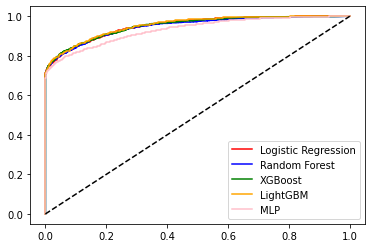

In [52]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
# line = mlines.Line2D([0,1],[0,1], color='black', linestyle='--')

# plt.plot(precision, recall)
plt.plot(fpr_lr, tpr_lr, color='red', label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, color='blue',label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, color='green',label='XGBoost')
plt.plot(fpr_lgbm, tpr_lgbm, color='orange',label='LightGBM')
plt.plot(fpr_mlp, tpr_mlp, color='pink',label='MLP')
plt.plot([0,1],[0,1], color='k',linestyle='--')
plt.legend()
plt.show()
# plot_precision_recall_curve(RSCV_lr, x_test, y_test)



### PRC Curve

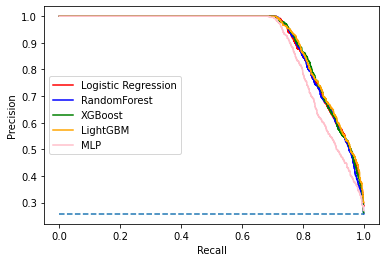

In [53]:
plt.plot(recall_lr, precision_lr, color='red', label='Logistic Regression')
plt.plot(recall_rf, precision_rf, color='blue',label='RandomForest')
plt.plot(recall_xgb, precision_xgb, color='green',label='XGBoost')
plt.plot(recall_lgbm, precision_lgbm, color='orange',label='LightGBM')
plt.plot(recall_mlp, precision_mlp, color='pink',label='MLP')
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1],[no_skill,no_skill], linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [359]:
# pd.DataFrame(RSCV_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_solver,param_penalty,param_multi_class,param_max_iter,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002603,0.000491,0.000000,0.000000,0.0006,liblinear,none,ovr,100,0.9,"{'tol': 0.0006000000000000001, 'solver': 'libl...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
1,2.611623,0.265417,0.001400,0.000490,0.0002,newton-cg,none,ovr,200,0.0,"{'tol': 0.0002, 'solver': 'newton-cg', 'penalt...",0.925367,0.930528,0.933307,0.930925,0.940429,0.932111,0.004899,2
2,0.005799,0.000979,0.000000,0.000000,0.0001,newton-cg,l1,auto,200,0.9,"{'tol': 0.0001, 'solver': 'newton-cg', 'penalt...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
3,0.801317,0.023296,0.002399,0.000488,0.0003,saga,none,ovr,100,0.2,"{'tol': 0.00030000000000000003, 'solver': 'sag...",0.741961,0.755062,0.764192,0.747122,0.768864,0.755440,0.010078,5
4,0.007600,0.002416,0.000000,0.000000,0.0007,sag,elasticnet,auto,200,0.8,"{'tol': 0.0007000000000000001, 'solver': 'sag'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
5,0.005799,0.000980,0.000000,0.000000,0.0002,newton-cg,elasticnet,ovr,400,0.1,"{'tol': 0.0002, 'solver': 'newton-cg', 'penalt...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
6,0.494732,0.326272,0.002798,0.000399,0.0007,liblinear,l1,ovr,400,0.5,"{'tol': 0.0007000000000000001, 'solver': 'libl...",0.926558,0.930131,0.933704,0.930925,0.941223,0.932508,0.004918,1
7,2.159988,0.039577,0.002000,0.000633,0.0009,sag,l2,auto,400,0.6,"{'tol': 0.0009000000000000001, 'solver': 'sag'...",0.770544,0.776896,0.783247,0.774117,0.830024,0.786965,0.021927,3
8,0.034006,0.002098,0.002802,0.000743,0.0007,saga,l1,multinomial,300,0.0,"{'tol': 0.0007000000000000001, 'solver': 'saga...",0.737594,0.743946,0.755855,0.734418,0.755759,0.745515,0.008946,6
9,2.297581,0.070180,0.001600,0.000490,0.0003,saga,l1,auto,300,0.9,"{'tol': 0.00030000000000000003, 'solver': 'sag...",0.750695,0.760222,0.765780,0.754665,0.785941,0.763461,0.012342,4


### Confusion Matrix

In [333]:
lr_pred_exact = np.argmax(lr.predict_proba(x_test),axis=1)
rf_pred_exact = np.argmax(rf.predict_proba(x_test),axis=1)
xgb_pred_exact= np.argmax(xgb.predict_proba(x_test),axis=1)
lgbm_pred_exact = np.argmax(lgbm.predict_proba(x_test),axis=1)

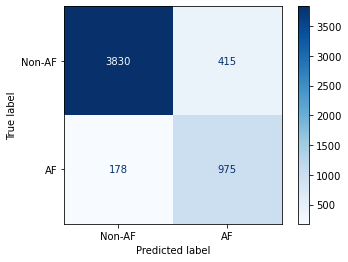

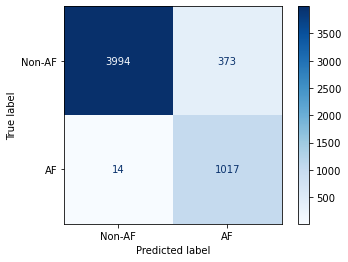

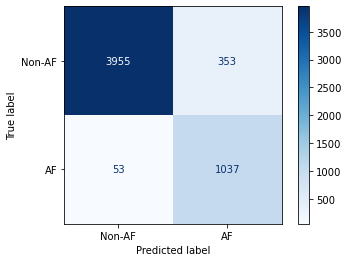

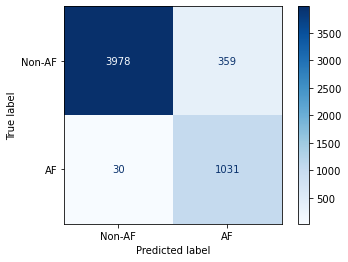

In [342]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

label = ['Non-AF','AF']
cm_lr = confusion_matrix(lr_pred_exact, y_test)
cmd_lr = ConfusionMatrixDisplay(cm_lr, display_labels=label)
cmd_lr.plot(cmap='Blues')


cm_rf = confusion_matrix(rf_pred_exact, y_test)
cmd_rf = ConfusionMatrixDisplay(cm_rf, display_labels=label)
cmd_rf.plot(cmap='Blues')

cm_xgb = confusion_matrix(xgb_pred_exact, y_test)
cmd_xgb = ConfusionMatrixDisplay(cm_xgb, display_labels=label)
cmd_xgb.plot(cmap='Blues')

cm_lgbm = confusion_matrix(lgbm_pred_exact, y_test)
cmd_lgbm = ConfusionMatrixDisplay(cm_lgbm, display_labels=label)
cmd_lgbm.plot(cmap='Blues')

### Calibration plot

In [54]:
from sklearn.calibration import calibration_curve

lr_y, lr_x = calibration_curve(y_test, RSCV_lr_pred, n_bins=10)
rf_y, rf_x = calibration_curve(y_test, RSCV_rf_pred, n_bins=10)
xgb_y, xgb_x = calibration_curve(y_test, RSCV_xgb_pred, n_bins=10, strategy='quantile')
lgbm_y, lgbm_x = calibration_curve(y_test, RSCV_lgbm_pred, n_bins=10)
mlp_y, mlp_x = calibration_curve(y_test, RSCV_mlp_pred, n_bins=10)

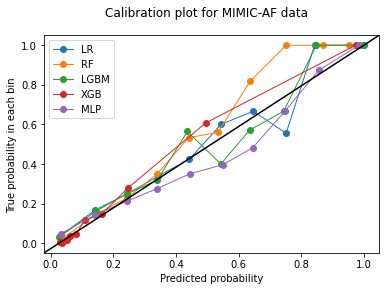

In [55]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
plt.plot(lr_x, lr_y, marker ='o', linewidth=1, label='LR')
plt.plot(rf_x, rf_y, marker ='o', linewidth=1, label='RF')
plt.plot(lgbm_x, lgbm_y, marker ='o', linewidth=1, label='LGBM')
plt.plot(xgb_x, xgb_y, marker ='o', linewidth=1, label='XGB')
plt.plot(mlp_x, mlp_y, marker ='o', linewidth=1, label='MLP')


line = mlines.Line2D([0,1],[0,1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
fig.suptitle('Calibration plot for MIMIC-AF data')

plt.legend()
plt.show()

### SHAP plot

In [69]:
import shap
import matplotlib.pyplot as plt

In [70]:
RSCV_xgb.best_params_

{'use_label_encoder': False,
 'objective': 'binary:logistic',
 'n_estimators': 370,
 'min_child_weight': 5,
 'learning_rate': 0.008,
 'gamma': 9,
 'booster': 'gbtree'}

In [71]:
xgb = XGBClassifier(objective='binary:logistic',
n_estimators=390, learning_rate=0.006,
min_child_weight=5, gamma=10,booster='gbtree').fit(x_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [72]:
explainer_xgb = shap.Explainer(xgb)
shapValues_xgb = explainer_xgb(x_test)
explainer_lgbm = shap.Explainer(xgb)
shapValues_lgbm = explainer_lgbm(x_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


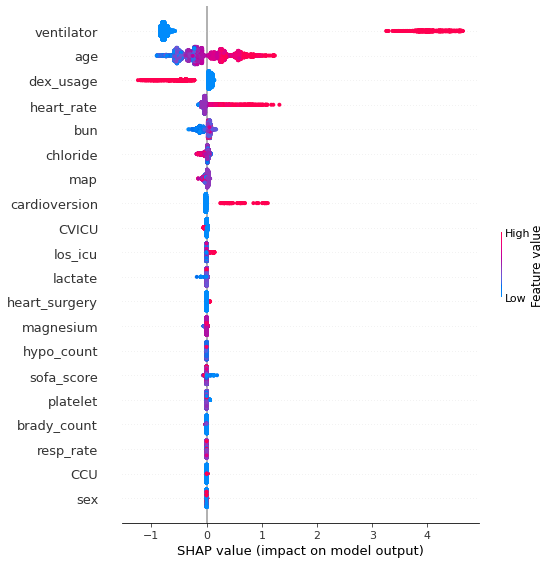

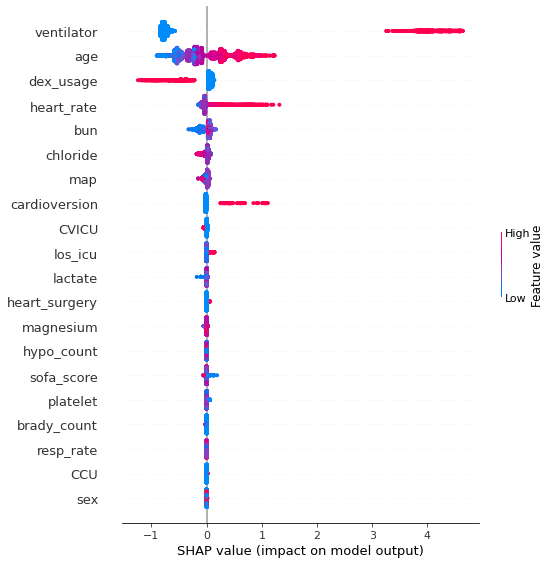

In [83]:
xgb_shap = shap.summary_plot(shapValues_xgb, x_test)
lgbm_shap = shap.summary_plot(shapValues_lgbm, x_test)


In [84]:

plt.gcf()


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [729]:
df.to_csv('df_new.csv')